## Resnet18

In [2]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_dir = "Split_Data"
batch_size = 32
num_epochs = 15
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Image Preprocessing

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## Load Dataset

In [5]:
def load_combined_dataset(split):
    datasets_list = []
    split_path = os.path.join(data_dir, split)
    for time_point in os.listdir(split_path):
        time_path = os.path.join(split_path, time_point)
        if os.path.isdir(time_path):
            ds = datasets.ImageFolder(time_path, transform=transform)
            datasets_list.append(ds)
    return torch.utils.data.ConcatDataset(datasets_list)

In [6]:
train_dataset = load_combined_dataset("train")
val_dataset = load_combined_dataset("val")
test_dataset = load_combined_dataset("test")

## DataLoaders for batching and optional shuffling of data

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Load Pre-trained Resnet Model

In [8]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Loss function: CrossEntropy (used for classification)
#### Optimizer: Adam optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Traning Loop

In [18]:
for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple

## Evaluation

In [12]:
def evaluate(loader, split_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)

    print(f"\n📊 {split_name} Performance:")
    print(classification_report(all_labels, all_preds, target_names=["pH5", "pH6", "pH7", "pH8"]))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["pH5", "pH6", "pH7", "pH8"],
                yticklabels=["pH5", "pH6", "pH7", "pH8"], cmap="Blues")
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


📊 Validation Performance:
              precision    recall  f1-score   support

         pH5       0.77      0.75      0.76        96
         pH6       0.80      0.76      0.78        94
         pH7       0.79      0.47      0.59        93
         pH8       0.60      0.88      0.71        98

    accuracy                           0.72       381
   macro avg       0.74      0.71      0.71       381
weighted avg       0.74      0.72      0.71       381



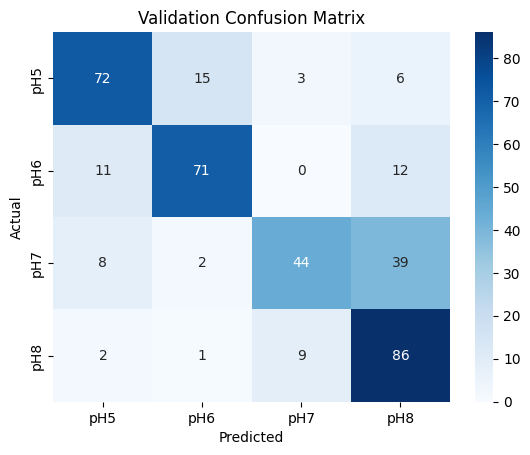


📊 Test Performance:
              precision    recall  f1-score   support

         pH5       0.81      0.84      0.83        99
         pH6       0.84      0.77      0.80        98
         pH7       0.94      0.63      0.75        94
         pH8       0.71      0.97      0.82        99

    accuracy                           0.80       390
   macro avg       0.82      0.80      0.80       390
weighted avg       0.82      0.80      0.80       390



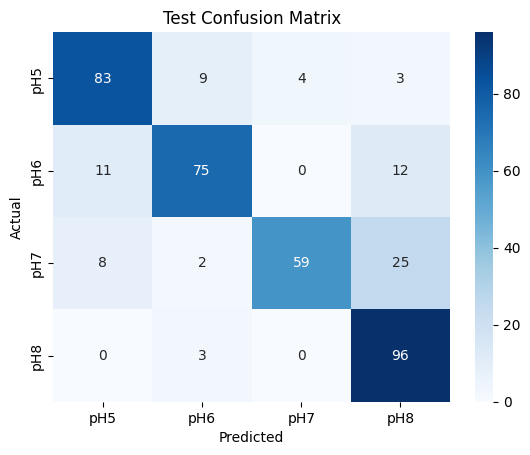

In [13]:
# Final evaluation
evaluate(val_loader, "Validation")
evaluate(test_loader, "Test")

## Model Summary

In [16]:
from torchsummary import summary
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,